In [2]:
import polars as pl
df = pl.read_csv("SAML-D.csv")
print(df.columns)


['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type']


In [7]:
import polars as pl
import networkx as nx
from tqdm import tqdm

# === [1] 讀取 CSV 檔 === #
print("🔍 讀取 SAML-D.csv 中...")
df = pl.read_csv("SAML-D.csv")

# === [2] 依時間排序，建立天然 DAG === #
print("🔄 依照 Date + Time 欄位排序...")
df_sorted = df.sort(["Date", "Time"])

# === [3] 建構金流圖 === #
print("🛠️  建構金流圖（預期為 DAG）...")
G = nx.DiGraph()
for row in tqdm(df_sorted.iter_rows(named=True), desc="建立交易邊", unit="筆"):
    sender = row["Sender_account"]
    receiver = row["Receiver_account"]
    G.add_edge(sender, receiver)

# === [4] 檢查是否為 DAG === #
print("✅ 檢查圖結構是否為 DAG...")
if nx.is_directed_acyclic_graph(G):
    print("🎉 成功建構為 DAG（金流圖無環）")
else:
    print("⚠️ 圖中仍存在環，建議後續使用 enforce_dag() 處理")

# === [5] 儲存邊列表檔案 === #
nx.write_edgelist(G, "SAML-D-DAG.edgelist", data=False)
print("📦 邊列表已儲存為：SAML-D-DAG.edgelist（位於相同資料夾）")


🔍 讀取 SAML-D.csv 中...
🔄 依照 Date + Time 欄位排序...
🛠️  建構金流圖（預期為 DAG）...


建立交易邊: 9504852筆 [00:41, 228706.42筆/s]


✅ 檢查圖結構是否為 DAG...
⚠️ 圖中仍存在環，建議後續使用 enforce_dag() 處理
📦 邊列表已儲存為：SAML-D-DAG.edgelist（位於相同資料夾）


[1/6] ➜ 讀取資料中...
[2/6] ➜ 建立圖並標記環...


⛏️ 檢查 DAG 結構: 9504852it [00:08, 1110734.88it/s]
C:\Users\Leon\AppData\Local\Temp\ipykernel_21768\255537680.py:39: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([



[2/6] ➜ 計算邊風險中...


📊 風險評估: 9504852it [00:29, 317229.72it/s]



[3/6] ➜ Tabu Search 最佳化門檻中...


🧠 Tabu Iterations:   0%|                                                    | 0/20 [00:00<?, ?it/s]







⚙️ TD-UF 遍歷中: 100%|██████████████████████████████████| 855460/855460 [00:01<00:00, 783629.85it/s]
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.








⚙️ TD-UF 遍歷中: 100%|██████████████████████████████████| 855460/855460 [00:01<00:00, 834286.88it/s]
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to sil


[4/6] ➜ 最佳風險門檻：0.90
[4/6] ➜ 使用最佳門檻執行 TD-UF 聚合...


⚙️ TD-UF 遍歷中: 100%|██████████████████████████████████| 855460/855460 [00:01<00:00, 612980.92it/s]
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



[6/6] === 最終模型評估結果 ===
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Precision |   0.063 |
+-----------+---------+
| Recall    |   0.538 |
+-----------+---------+
| F1 Score  |   0.113 |
+-----------+---------+


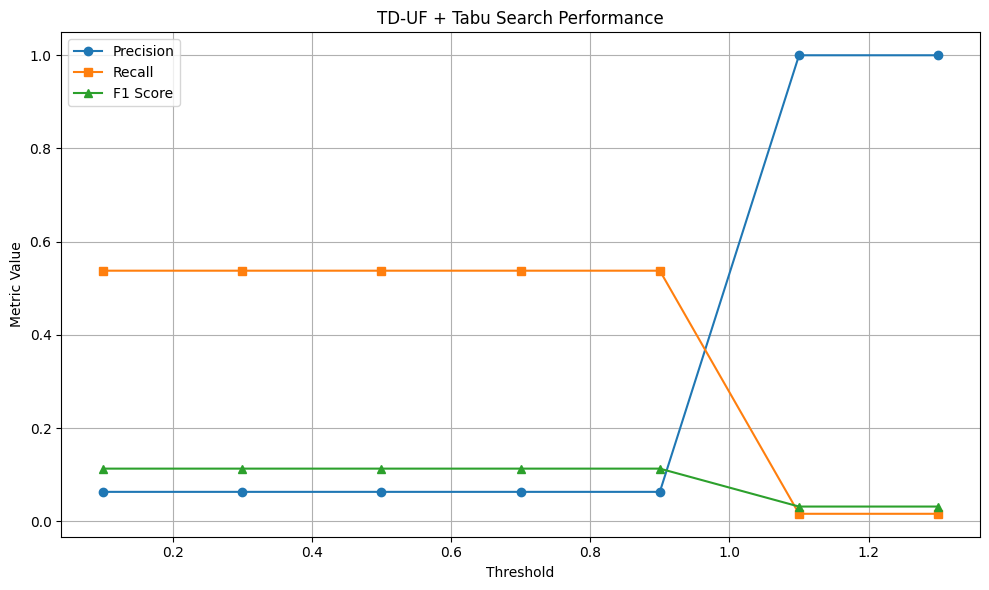

In [1]:
# === TD-UF + Tabu Search 模型（純 polars 實作，無 NetworkX）=== #
import polars as pl
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import defaultdict, deque

# === 自建 DAG 結構並移除形成環的邊 === #
def enforce_dag_and_mark(df):
    graph = defaultdict(list)
    in_degree = defaultdict(int)
    removed_edges = set()
    seen_edges = set()

    for u, v in tqdm(df.select(["Sender_account", "Receiver_account"]).iter_rows(), desc="⛏️ 檢查 DAG 結構", ncols=100):
        if (u, v) in seen_edges:
            continue
        seen_edges.add((u, v))
        graph[u].append(v)
        in_degree[v] += 1
        # Cycle check: 做 BFS 判斷是否 v 可達 u
        queue, visited = deque([v]), set()
        found_cycle = False
        while queue:
            cur = queue.popleft()
            if cur == u:
                found_cycle = True
                break
            for nei in graph.get(cur, []):
                if nei not in visited:
                    visited.add(nei)
                    queue.append(nei)
        if found_cycle:
            graph[u].pop()
            in_degree[v] -= 1
            removed_edges.add((u, v))

    df = df.with_columns([
        (pl.struct(["Sender_account", "Receiver_account"])
         .map_elements(lambda x: int((x["Sender_account"], x["Receiver_account"]) in removed_edges))
         .alias("CycleFlag"))
    ])
    df = df.with_columns([
        (pl.col("Is_laundering") | pl.col("CycleFlag")).cast(pl.Int8).alias("Is_laundering")
    ])
    return graph, in_degree, df

# === Topological sort（Kahn algorithm）=== #
def topological_sort(graph, in_degree):
    order = []
    zero_in = deque([u for u in graph if in_degree[u] == 0])
    while zero_in:
        u = zero_in.popleft()
        order.append(u)
        for v in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                zero_in.append(v)
    return order

# === TD-UF 演算法 === #
def td_uf(graph, topo_order, threshold, risk_dict):
    parent = {}
    def find(x):
        if parent.get(x, x) != x:
            parent[x] = find(parent[x])
        return parent.get(x, x)
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[py] = px

    for u in tqdm(topo_order, desc="⚙️ TD-UF 遍歷中", ncols=100):
        for v in graph.get(u, []):
            risk = risk_dict.get((u, v), 0)
            if risk >= threshold:
                union(u, v)
    return parent

# === 邊風險計算 === #
def compute_edge_risk(df):
    print("\n[2/6] ➜ 計算邊風險中...")
    risk_dict = {}
    for row in tqdm(df.iter_rows(named=True), desc="📊 風險評估", ncols=100):
        risk = 0.0
        if row["Is_laundering"] == 1:
            risk += 1.5
        if row["Amount"] > 5000:
            risk += 1.0
        try:
            hour = int(row["Time"])
        except:
            hour = 12
        if hour < 6 or hour > 22:
            risk += 0.5
        risk_dict[(row["Sender_account"], row["Receiver_account"])] = risk
    return risk_dict

# === 分群結果評估 === #
def evaluate_result(df, parent):
    df_group = df.with_columns([
        pl.struct(["Sender_account"]).map_elements(lambda x: parent.get(x["Sender_account"], x["Sender_account"])).alias("group_origin"),
        pl.struct(["Receiver_account"]).map_elements(lambda x: parent.get(x["Receiver_account"], x["Receiver_account"])).alias("group_benef")
    ])
    y_true = df_group["Is_laundering"].to_list()
    y_pred = [(g1 == g2) for g1, g2 in zip(df_group["group_origin"], df_group["group_benef"])]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return precision, recall, f1

# === Tabu Search === #
def tabu_search(graph, in_degree, df, risk_dict, max_iter=20, tabu_len=5):
    print("\n[3/6] ➜ Tabu Search 最佳化門檻中...")
    current = 1.5
    best = current
    best_score = 0
    tabu = []
    history = []
    topo_order = topological_sort(graph, in_degree.copy())
    for _ in tqdm(range(max_iter), desc="🧠 Tabu Iterations", ncols=100):
        neighbors = [current + delta for delta in [-0.2, 0, 0.2] if 0.1 <= current + delta <= 3.0]
        candidates = []
        for th in tqdm(neighbors, desc="  🔍 評估鄰近門檻", leave=False, ncols=100):
            parent = td_uf(graph, topo_order, th, risk_dict)
            precision, recall, f1 = evaluate_result(df, parent)
            score = 0.6 * recall + 0.4 * f1
            candidates.append((th, precision, recall, f1, score))
        candidates = [c for c in candidates if c[0] not in tabu]
        if not candidates:
            break
        best_candidate = max(candidates, key=lambda x: x[4])
        current = best_candidate[0]
        history.append(best_candidate)
        if best_candidate[4] > best_score:
            best_score = best_candidate[4]
            best = best_candidate[0]
        tabu.append(current)
        if len(tabu) > tabu_len:
            tabu.pop(0)
    return best, history, topo_order

# === 畫圖 === #
def plot_history(history):
    thresholds = [h[0] for h in history]
    precisions = [h[1] for h in history]
    recalls = [h[2] for h in history]
    f1s = [h[3] for h in history]
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, marker='o', label='Precision')
    plt.plot(thresholds, recalls, marker='s', label='Recall')
    plt.plot(thresholds, f1s, marker='^', label='F1 Score')
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("TD-UF + Tabu Search Performance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 主程式 === #
def main():
    print("[1/6] ➜ 讀取資料中...")
    df = pl.read_csv("SAML-D.csv")

    print("[2/6] ➜ 建立圖並標記環...")
    graph, in_degree, df = enforce_dag_and_mark(df)

    risk_dict = compute_edge_risk(df)
    best_threshold, history, topo_order = tabu_search(graph, in_degree, df, risk_dict)

    print(f"\n[4/6] ➜ 最佳風險門檻：{best_threshold:.2f}")
    print("[4/6] ➜ 使用最佳門檻執行 TD-UF 聚合...")
    final_parent = td_uf(graph, topo_order, best_threshold, risk_dict)
    precision, recall, f1 = evaluate_result(df, final_parent)

    results_table = [
        ["Metric", "Score"],
        ["Precision", f"{precision:.3f}"],
        ["Recall",    f"{recall:.3f}"],
        ["F1 Score",  f"{f1:.3f}"]
    ]
    print("\n[6/6] === 最終模型評估結果 ===")
    print(tabulate(results_table, headers="firstrow", tablefmt="grid"))

    plot_history(history)

if __name__ == "__main__":
    main()
